### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls lib

YearPlotter.py   computeStats.py  recon_plot.py    row_parser.pyc
YearPlotter.pyc  computeStats.py~ recon_plot.pyc   spark_PCA.py
YearPlotter.tmp  numpy_pack.py    recon_plot.py~
binary_search.py numpy_pack.pyc   row_parser.py


In [3]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions
from recon_plot import recon_plot
from YearPlotter import YearPlotter

In [5]:
data_dir='../../Data/Weather'
file_index='BBBSBBBB'

### Read the data frame from pickle file

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [7]:
#read data
filename=data_dir+'/US_Weather_BBBSBBBB.csv'
List=load(open(filename,'rb'))
print 'length of List=',len(List)

df=sqlContext.createDataFrame(List)
print df.count()
df.show(5)

length of List= 13047
13047
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[80 4D 00 46 E0 5...|1931.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[00 4F 80 51 00 4...|1932.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[20 D0 00 53 A0 5...|1933.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[30 55 80 C9 A0 D...|1934.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     1|[E0 50 00 CF 00 5...|1935.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Read and process sample data

In [8]:
sqlContext.registerDataFrameAsTable(df,'weather')
#Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNWD','USC00198301')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('SNWD')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='SNWD'
1321 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       SNWD|USC00198301|     2|[00 00 00 00 00 0...|1949.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       SNWD|USC00198301|    30|[00 00 00 00 00 0...|1950.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(1321, 365)

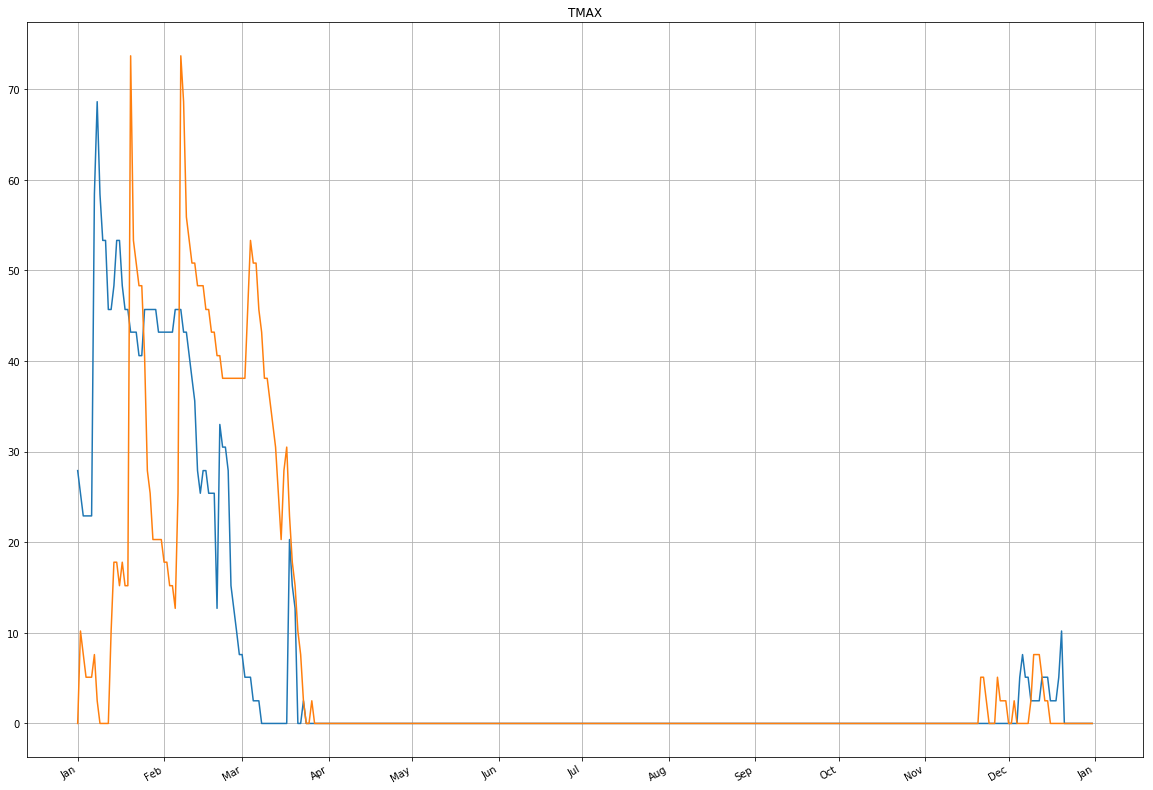

In [9]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(20,15));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title='TMAX')

### Plot Reconstructions

From each measurement, we take 4 sample stations with low residual error and 4 sample stations with high residual error and plot the following:

* Original Data Vector
* Reconstructed Data Vector from top 1 eigen vectors
* Reconstructed Data Vector from top 2 eigen vectors
* Reconstructed Data Vector from top 3 eigen vectors

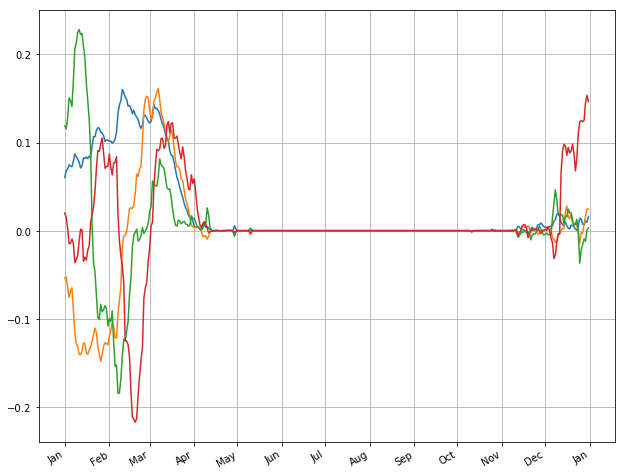

In [10]:
k=4
m='SNWD'
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
target=T[16,:]*10
fig=plt.figure(figsize=(8,6))
ax=fig.add_axes([0,0,1,1])
YearPlotter().plot(EigVec,fig,ax,label='snow Depth')

4


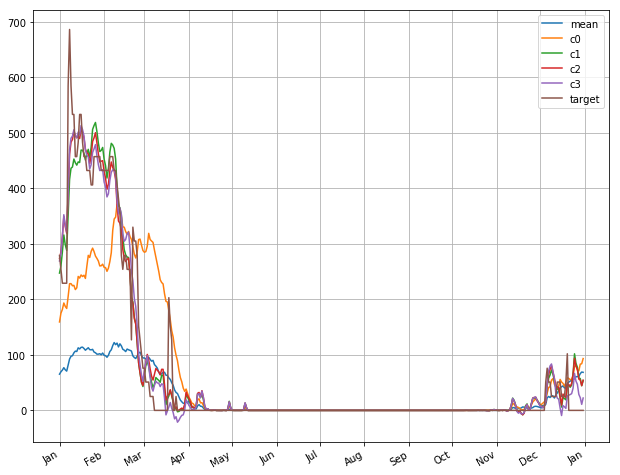

In [11]:
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
print len(v)
recon_plot(None,target,Mean,v,year_axis=True);

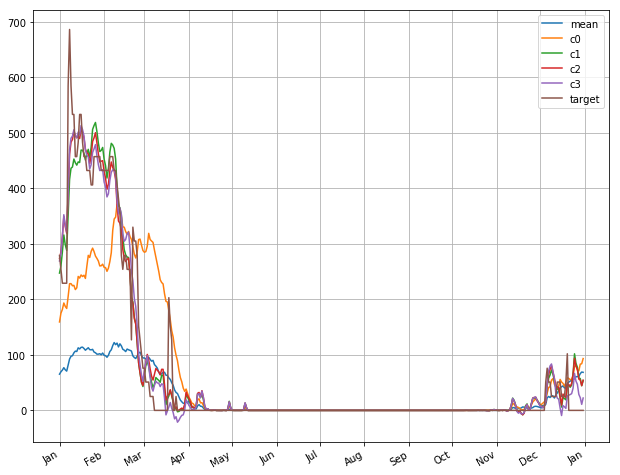

In [12]:
import numpy as np
from ipywidgets import interactive,widgets
plotter=recon_plot(None,target,Mean,v,year_axis=True);
widge_list,widge_dict = plotter.get_widgets()
interactive(plotter.plot_combination, **widge_dict)
widgets.VBox([widgets.HBox(widge_list)])


In [13]:
def create_reconstructions(m):  
    Prod={}
    for k in range(1,4):
        Eigen=np.matrix(STAT[m]['eigvec'][:,:k])
        matrix=np.matrix(m_df[m].ix[:,2:367])-STAT[m]['Mean']
        matrix[isnan(matrix)]=0
        Prod[k]=matrix*Eigen
    Reconstructed={}
    for k in range(1,4):
        Eigen=np.matrix(STAT[m]['eigvec'][:,:k])
        Reconstructed[k]=array(Eigen*Prod[k].transpose()+STAT[m]['Mean'][:,np.newaxis])
        
    original=np.array(m_df[m].ix[:,2:367])-STAT[m]['Mean']
    residue_list=[]
    for i in range(len(Reconstructed[1][0])):
        vec_diff=original[i]-Reconstructed[3][:,i]
        residue=np.linalg.norm(vec_diff)
        residue_list.append((residue,i))
    residue_list=[x for x in residue_list if not math.isnan(x[0])]
    residue_list=sorted(residue_list)
    
    lower=[i for (r,i) in residue_list[:4]]
    upper=[i for (r,i) in residue_list[-4:]]
    
    yeardays=[i for i in (1,366)]
    plt.figure(figsize=(20,9),dpi=300)
    j=1
    c=0
    for l in lower:
        subplot(2,4,j)
        j+=1
        c+=1
        plot(original[l])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (low residual error)')
        xlim([0,365])
        legend(['original','1','2','3'],loc=2)
    
    c=0
    for l in upper:
        subplot(2,4,j)
        j+=1
        c+=1
        plot(original[l])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (high residual error)')
        xlim([0,365])
        legend(['original','1','2','3'],loc=2)


In [14]:
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    print 'Reconstruction Plots for '+ m
    create_reconstructions(m)

Reconstruction Plots for TMIN


NameError: global name 'm_df' is not defined